<a href="https://colab.research.google.com/github/sugi-san/hyperstyle/blob/main/hyperstyle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

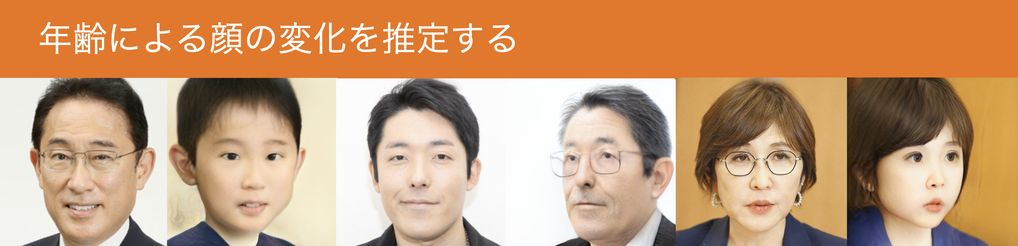

In [ ]:
#@title **1.セットアップ**
import os
os.chdir('/content')
CODE_DIR = 'hyperstyle'

# clone repo
!git clone https://github.com/sugi-san/hyperstyle.git $CODE_DIR

# install ninja
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
os.chdir(f'./{CODE_DIR}')


# Import Packages
import time
import sys
import pprint
from tqdm import tqdm
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

import imageio
from IPython.display import HTML
from base64 import b64encode

sys.path.append(".")
sys.path.append("..")

from notebooks.notebook_utils import Downloader, HYPERSTYLE_PATHS, W_ENCODERS_PATHS, run_alignment
from utils.common import tensor2im
from utils.inference_utils import run_inversion
from utils.domain_adaptation_utils import run_domain_adaptation
from utils.model_utils import load_model, load_generator
from function import *

%load_ext autoreload
%autoreload 2


# download pretrained_models
! pip install --upgrade gdown
import gdown
import time
for i in range(10):
  if os.path.exists('pretrained_models.zip'):
    break
  else:
    gdown.download('https://drive.google.com/uc?id=1NxGZfkE3THgEfPHbUoLPjCKfpWTo08V1', 'pretrained_models.zip', quiet=False)
    time.sleep(1)
! unzip pretrained_models.zip


# set expeiment data
EXPERIMENT_DATA_ARGS = {
    "faces": {
        "model_path": "./pretrained_models/hyperstyle_ffhq.pt",
        "w_encoder_path": "./pretrained_models/faces_w_encoder.pt",
        "image_path": "./notebooks/images/face_image.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
    "cars": {
        "model_path": "./pretrained_models/hyperstyle_cars.pt",
        "w_encoder_path": "./pretrained_models/cars_w_encoder.pt",
        "image_path": "./notebooks/images/car_image.jpg",
        "transform": transforms.Compose([
            transforms.Resize((192, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
    "afhq_wild": {
        "model_path": "./pretrained_models/hyperstyle_afhq_wild.pt",
        "w_encoder_path": "./pretrained_models/afhq_wild_w_encoder.pt",
        "image_path": "./notebooks/images/afhq_wild_image.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    }
}

experiment_type = 'faces'
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]


# Load HyperStyle Model
model_path = EXPERIMENT_ARGS['model_path']
net, opts = load_model(model_path, update_opts={"w_encoder_checkpoint_path": EXPERIMENT_ARGS['w_encoder_path']})
print('Model successfully loaded!')


# difine function
def generate_mp4(out_name, images, kwargs):
    writer = imageio.get_writer(out_name + '.mp4', **kwargs)
    for image in tqdm(images):
        writer.append_data(image)
    writer.close()


def get_latent_and_weight_deltas(inputs, net, opts):
    opts.resize_outputs = False
    opts.n_iters_per_batch = 5
    with torch.no_grad():
        _, latent, weights_deltas, _ = run_inversion(inputs.to("cuda").float(), net, opts)
    weights_deltas = [w[0] if w is not None else None for w in weights_deltas]
    return latent, weights_deltas
    

def get_result_from_vecs(vectors_a, vectors_b, weights_deltas_a, weights_deltas_b, alpha):
    results = []
    for i in range(len(vectors_a)):
        with torch.no_grad():
            cur_vec = vectors_b[i] * alpha + vectors_a[i] * (1 - alpha)
            cur_weight_deltas = interpolate_weight_deltas(weights_deltas_a, weights_deltas_b, alpha)
            res = net.decoder([cur_vec],
                              weights_deltas=cur_weight_deltas,
                              randomize_noise=False,
                              input_is_latent=True)[0]
            results.append(res[0])
    return results

def interpolate_weight_deltas(weights_deltas_a, weights_deltas_b, alpha):
    cur_weight_deltas = []
    for weight_idx, w in enumerate(weights_deltas_a):
        if w is not None:
            delta = weights_deltas_b[weight_idx] * alpha + weights_deltas_a[weight_idx] * (1 - alpha)
        else:
            delta = None
        cur_weight_deltas.append(delta)
    return cur_weight_deltas
    
def show_mp4(filename, width):
    mp4 = open(filename + '.mp4', 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML("""
    <video width="%d" controls autoplay loop>
        <source src="%s" type="video/mp4">
    </video>
    """ % (width, data_url)))


# downloadフォルダ作成
import os
os.makedirs('download', exist_ok=True)

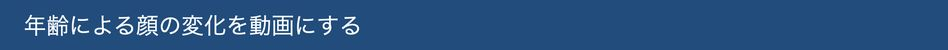

In [ ]:
#@title **2.写真の表示**
display_pic('./images/pic')

In [ ]:
#@title **3.顔の切り出し**

# --- align処理 ---
import glob
from tqdm import tqdm

reset_folder('./images/align')
files = sorted(glob.glob('./images/pic/*.jpg'))
for file in tqdm(files):
    aligned_image = run_alignment(file)
    name = os.path.basename(file)
    aligned_image.save('./images/align/'+name)
    

# --- 反転処理 ---
import glob
from tqdm import tqdm
image_paths = sorted(glob.glob('./images/align/*.jpg'))

in_images = []
all_vecs = []
all_weights_deltas = []
img_transforms = EXPERIMENT_ARGS['transform']

if experiment_type == "cars":
    resize_amount = (512, 384)
else:
    resize_amount = (opts.output_size, opts.output_size)

for image_path in tqdm(image_paths):
    #print(f'Working on {os.path.basename(image_path)}...')
    original_image = Image.open(image_path)
    original_image = original_image.convert("RGB")
    input_image = img_transforms(original_image)
    # get the weight deltas for each image
    result_vec, weights_deltas = get_latent_and_weight_deltas(input_image.unsqueeze(0), net, opts)
    all_vecs.append([result_vec])
    all_weights_deltas.append(weights_deltas)
    in_images.append(original_image.resize(resize_amount))

display_pic('images/align')

In [ ]:
#@title **4.動画の作成**

# インデックス指定
input = '04.jpg'#@param {type:"string"}
names = [os.path.basename(x) for x in image_paths]
pic_idx = names.index(input)

# 編集係数
#@markdown ・年齢上限をmaxで、年齢下限をminで設定する（標準はmax=50, min=-50）
max = 50 #@param {type:"slider", min:40, max:70, step:5}
min = -50 #@param {type:"slider", min:-70, max:-40, step:5}

# 編集用ベクトル作成
age = torch.load('editing/interfacegan_directions/age.pt').to('cuda')
age = torch.reshape(age,(1, 1, 512))
pose = torch.load('editing/interfacegan_directions/pose.pt').to('cuda')
pose = torch.reshape(pose,(1, 18, 512))
w = pose*0.8+age

# 画像生成関数
def result_img(cur_vec, cur_weight_deltas):
  res = net.decoder([cur_vec],
                   weights_deltas=cur_weight_deltas,
                   randomize_noise=False,
                   input_is_latent=True)[0]
  output_im = tensor2im(res[0])
  return output_im


# フレーム作成
reset_folder('im')
from tqdm import tqdm

num = 0
for i  in tqdm(range(0, min, -1)):
  cur_vec = all_vecs[pic_idx][0]+w*i/10
  cur_weight_deltas = all_weights_deltas[pic_idx]
  output_im = result_img(cur_vec, cur_weight_deltas)
  output_im.save('im/'+str(num).zfill(4)+'.jpg') 
  num +=1  

for j  in tqdm(range(min, max)):
  cur_vec = all_vecs[pic_idx][0]+w*j/10
  cur_weight_deltas = all_weights_deltas[pic_idx]
  output_im = result_img(cur_vec, cur_weight_deltas)
  output_im.save('im/'+str(num).zfill(4)+'.jpg') 
  num +=1

for k  in tqdm(range(max, 0, -1)):
  cur_vec = all_vecs[pic_idx][0]+w*k/10
  cur_weight_deltas = all_weights_deltas[pic_idx]
  output_im = result_img(cur_vec, cur_weight_deltas)
  output_im.save('im/'+str(num).zfill(4)+'.jpg') 
  num +=1    


# 連結フレームの作成
import cv2
import glob

reset_folder('im2')
img1 = cv2.imread('images/align/'+input)

files = sorted(glob.glob('im/*.jpg'))
for i, file in enumerate(tqdm(files)):
  img2 = cv2.imread(file)
  img3 = cv2.hconcat([img1, img2])
  cv2.imwrite('im2/'+str(i).zfill(4)+'.jpg', img3)


# 動画作成&再生
print('making movie...')
! ffmpeg -y -r 20 -i im/%04d.jpg -vcodec libx264 -pix_fmt yuv420p -loglevel error output.mp4
! ffmpeg -y -r 20 -i im2/%04d.jpg -vcodec libx264 -pix_fmt yuv420p -loglevel error output2.mp4
show_mp4('output2', 600)

In [ ]:
#@title **5.動画のダウンロード**

#@markdown ・右の動画のみダウンロードする場合は、onlyにチェックを入れて下さい

import shutil

only = False #@param {type:"boolean"}

if only == True:
  download_name = 'download/'+os.path.splitext(input)[0]+'_o.mp4'
  shutil.copy('output.mp4', download_name)
else:
  download_name = 'download/'+os.path.splitext(input)[0]+'.mp4'
  shutil.copy('output2.mp4', download_name)

from google.colab import files
files.download(download_name)

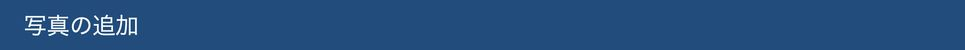

In [ ]:
#@title **6.写真のアップロード**
#@markdown ・1人の顔だけが写っている写真を使って下さい
# ルートへ画像をアップロード
from google.colab import files
reset_folder('pic')
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートから指定フォルダーへ移動
for file in uploaded:
    shutil.move(file, 'pic')

display_pic('pic')


###【備考】
・ブラウザは、必ずGoogle Chromeを使用して下さい。

・動作がおかしくなった場合の対応\
１）グーグルクロームの該当タブを削除して接続を切る\
２）再度リンクを開く\
３）右上にある「ランタイム／ランタイムを出荷時設定にリセット」をクリックする（下記写真を参照に下さい）\
４）あとは、動画にある通りの操作をすればOK

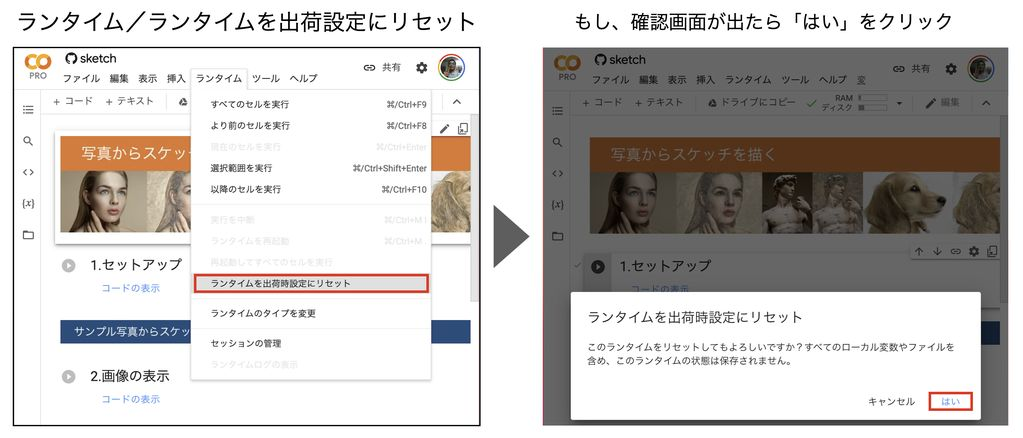